In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 下載並整理MNIST資料集

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [5]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

In [6]:
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [7]:
y_train_n及w = to_categorical(y_train, 10)
y_test_new = to_categorical(y_test, 10)

## 建立VAE

In [11]:
enc_1 = Dense(256, activation='sigmoid')
enc_2 = Dense(128, activation='sigmoid')
enc_3 = Dense(64, activation='relu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_1 = Dense(64, activation='relu')
dec_2 = Dense(128, activation='sigmoid')
dec_3 = Dense(256, activation='sigmoid')
dec_4 = Dense(784, activation='sigmoid')

In [12]:
x = Input(shape=(784,))
enc_x = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [13]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [15]:
x_hat = dec_4(dec_3(dec_2(dec_1(z))))

In [16]:
VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## 建立Loss函數

In [17]:
reconstruction_loss = 784 * losses.binary_crossentropy(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

## 訓練VAE模型

In [28]:
VAE.compile(optimizer=Adam())

In [29]:
VAE.fit(x_train, 
        batch_size=256, 
        epochs=15) ##batch_size=256; 訓練15次

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 7s 124us/sample - loss: 217.5796
Epoch 2/15
60000/60000 [==============================] - 5s 89us/sample - loss: 197.2668
Epoch 3/15
60000/60000 [==============================] - 6s 92us/sample - loss: 191.5133
Epoch 4/15
60000/60000 [==============================] - 5s 91us/sample - loss: 188.4595
Epoch 5/15
60000/60000 [==============================] - 5s 88us/sample - loss: 183.4165
Epoch 6/15
60000/60000 [==============================] - 5s 90us/sample - loss: 174.7819
Epoch 7/15
60000/60000 [==============================] - 5s 87us/sample - loss: 169.9032
Epoch 8/15
60000/60000 [==============================] - 5s 88us/sample - loss: 166.7046
Epoch 9/15
60000/60000 [==============================] - 5s 86us/sample - loss: 164.1137
Epoch 10/15
60000/60000 [==============================] - 5s 88us/sample - loss: 161.7820
Epoch 11/15
60000/60000 [==============================] - 5s 87us/sample -

## VAE視覺化

In [39]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 242,242
Trainable params: 242,242
Non-trainable params: 0
_________________________________________________________________


In [40]:
z_input = Input(shape=(2,))

In [41]:
VAE_Decoder = Model(z_input, dec_4(dec_3(dec_2(dec_1(z_input)))))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 784)               201488    
Total params: 243,024
Trainable params: 243,024
Non-trainable params: 0
_________________________________________________________________


### 先做Encoder的部分

In [42]:
idx = np.random.randint(x_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(x_train[idx: idx+1]).squeeze()}")

第 15559 圖的 latent 表示為 [-0.72433615  1.7372477 ]


In [43]:
indices = np.random.randint(x_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_train[indices])

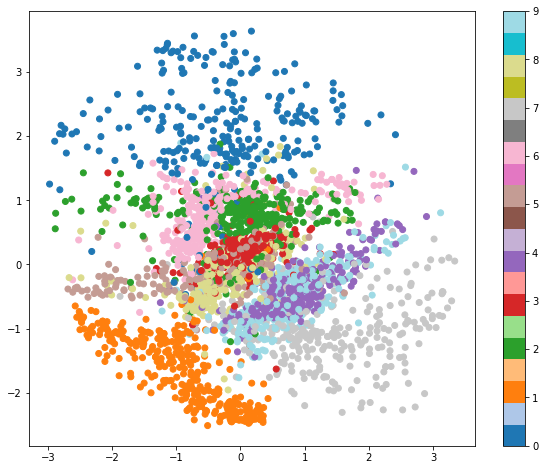

In [44]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train[indices], cmap='tab20')
plt.colorbar()
plt.show()

### 再來換Decoder的部分

In [45]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [46]:
n = 30
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

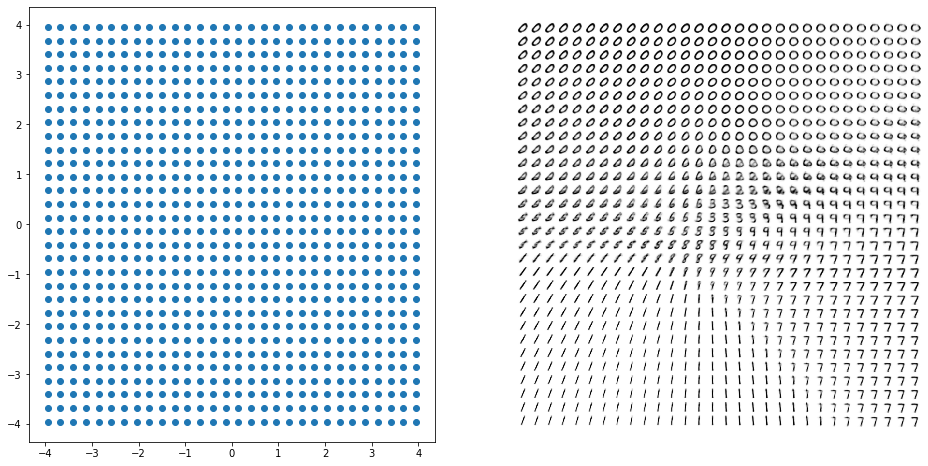

In [47]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

## 動態比較

In [48]:
idx_1, idx_2 = np.random.randint(x_train.shape[0], size=2)

In [49]:
def inBetween(t):
    data_0 = x_train[idx_1].reshape(28, 28)
    data_1 = x_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [50]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>